### Imports

In [300]:
import numpy as np
import pandas as pd
from case_studies import *
import time
import matplotlib.pyplot as plt

In [301]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f4]
dfs = [df1, df4]
Hfs = [Hf1, Hf4]
fnames = ["f1", "f4"]

In [302]:
def backtracking_line_search(f, df, x, pk, alpha_init, c1, rho):
    
    alpha = alpha_init
    while f(x + alpha * pk) > f(x) + c1 * alpha * np.dot(df(x), pk):
        alpha *= rho
    return alpha

In [303]:
def newtons_method(x0, f, grad_f, hessian_f, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    """
    Implements Newton's Method with a modified Hessian when necessary.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        hessian_f: Hessian (second derivative) of f.
        x0: Initial point.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
        tol: Tolerance for stopping condition.
        max_iters: Maximum number of iterations.
    
    Returns:
        x: Estimated minimum.
        xs: List of iterates for analysis.
    """
    x = x0
    xs = [x0]
    
    for _ in range(max_iters):
        grad = grad_f(x)
        hessian = hessian_f(x)
        
        if np.linalg.norm(grad) < tol:
            break 
        
        if np.all(np.linalg.eigvals(hessian) > 0):
            p = -np.linalg.solve(hessian, grad)
        else:
            eigvals, eigvecs = np.linalg.eigh(hessian)
            H = sum((1 / abs(eigval)) * np.outer(eigvec, eigvec) for eigval, eigvec in zip(eigvals, eigvecs))
            p = -H @ grad
        
        alpha = backtracking_line_search(f, grad_f, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)
    
    return x, xs

In [304]:
def steepest_descent(x0, f, df, c1=1e-4, rho=0.9, tol=1e-6, max_iters=1000):
    """
    Implements the Steepest Descent Algorithm with Backtracking Line Search.
    
    Parameters:
        f: Function to minimize.
        grad_f: Gradient of f.
        x0: Initial point.
        c1: Armijo condition parameter.
        rho: Reduction factor for step size.
        tol: Tolerance for stopping condition.
        max_iters: Maximum number of iterations.
    
    Returns:
        x: Estimated minimum.
        xs: List of iterates for analysis.
    """
    x=x0
    beta = 1.0
    xs = [x0]
    
    for _ in range(max_iters):
        pk = -df(x)
        if np.linalg.norm(pk) < tol:
            break
        
        alpha = backtracking_line_search(f, df, x, pk, beta, c1, rho)
        x = x + alpha * pk
        beta = alpha / rho
        xs.append(x)
    
    return x, xs


### Conjugate Gradients

In [305]:
#Max iter afhænger nok af newton som kalder CG, måske skal det hedde noget andet
def conjugate_gradients(Q, g, eps, max_iter=1000):
    x = 0
    grad = g
    p = -grad
    counter = 0
    for i in range(max_iter):
        alpha_k = -(np.dot(p, grad) / np.dot(p, np.dot(Q, p)))

        x = x + alpha_k * p
        
        grad = np.dot(Q, x) + g
        
        if np.linalg.norm(grad) < eps:
            break

        p = -grad + (np.dot(grad, np.dot(Q, p)) / np.dot(p, np.dot(Q, p))) * p
        grad = grad
        counter += 1
    return x, counter

### Approximate Newton

In [306]:
def approximate_newton(x, f, df, hf, c1=1e-4, rho=0.9, max_iter=1000, tol=1e-6):
    xs = [x]
    cg_count_per_iter = []
    for i in range(max_iter):

        if np.linalg.norm(df(x)) < tol:
            cg_count_per_iter.append(0)
            break 
        
        n_k = 0.5 * min(0.5, np.sqrt(np.linalg.norm(df(x))))
        eps = n_k * np.linalg.norm(df(x))
        p, counter = conjugate_gradients(hf(x), df(x), eps)
        alpha = backtracking_line_search(f, df, x, p, 1.0, c1, rho)
        x = x + alpha * p
        xs.append(x)

        cg_count_per_iter.append(counter)
    return x, xs, cg_count_per_iter

### Benchmarking

In [307]:
def benchmark(f, df, optimizer, x0, x_opt, Hf=None):
    start_time = time.time()
    if optimizer == steepest_descent:
        x_final, xs = optimizer(x0, f, df)
    if optimizer == newtons_method:
        x_final, xs = optimizer(x0, f, df, Hf)
    if optimizer == approximate_newton:
        x_final, xs, cg_count_per_iter = optimizer(x0, f, df, Hf)
    # steepest skal ikke have HF
    end_time = time.time()

    num_iterations = len(xs)
    final_solution_point = x_final
    dist_to_optimum = np.linalg.norm(x_final-x_opt)
    final_fun_value = f(xs[-1])
    duration = end_time-start_time
    
    grad_norms = [np.linalg.norm(df(x)) for x in xs]
    if optimizer == approximate_newton:
        return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms, cg_count_per_iter)

    return (num_iterations, duration, final_fun_value, final_solution_point, dist_to_optimum, grad_norms)


In [308]:
x0 = np.random.randn(20)
# print(x0.shape)
benchmark_results = []

#approx newton
for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, 20)
    # print(x_optimal.shape)
    sd_result = benchmark(f, df, approximate_newton, x0, x_optimal, Hf)
    benchmark_results.append((fname, "Approximate newton") + sd_result)

# original newton
for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, 20)
    # print(x_optimal.shape)
    sd_result = benchmark(f, df, newtons_method, x0, x_optimal, Hf)
    benchmark_results.append((fname, "Original newton") + sd_result)

#steepest descent 
for f, df, Hf, fname in zip(fs, dfs, Hfs, fnames):
    x_optimal = x_opt(f, 20)
    # print(x_optimal.shape)
    sd_result = benchmark(f, df, steepest_descent, x0, x_optimal, Hf)
    benchmark_results.append((fname, "Steepest descent") + sd_result)
# Convert to DataFrame
columns = ["Function", "Optimizer", "Iterations", "Time", "Final Function Value", "Final Solution Point", "Distance to Optimum", "Gradient Norms", "CG iterations per Newton iteration"]
df_results = pd.DataFrame(benchmark_results, columns=columns)

df_results

,Function,Optimizer,Iterations,Time,Final Function Value,Final Solution Point,Distance to Optimum,Gradient Norms,CG iterations per Newton iteration
0,f1,Approximate newton,10,0.007001,4.279003e-16,"[2.066736224041045e-09, 1.7041214760480165e-08...",1.724439e-08,"[3182.687007395956, 392.33615811211706, 70.995...","[1, 4, 8, 10, 13, 13, 14, 18, 21, 0]"
1,f4,Approximate newton,10,0.009999,1.220319e-04,"[0.0019093298361097116, 0.001909329834205777, ...",8.538764e-03,"[641.6206446345346, 6.227470409190537, 0.30956...","[0, 1, 1, 1, 3, 1, 1, 0, 0, 0]"
2,f1,Original newton,2,0.009996,1.640304e-30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.665335e-16,"[3182.687007395956, 2.3295038648687318e-14]",None
3,f4,Original newton,8,0.030003,1.220319e-04,"[0.001909331076337135, 0.001909331076337135, 0...",8.538788e-03,"[641.6206446345346, 0.3068849944005777, 0.0952...",None
4,f1,Steepest descent,1001,0.337996,1.498442e-02,"[0.1008977723191485, 0.03748084121359451, -0.0...",1.129292e-01,"[3182.687007395956, 3136.8651599001573, 2816.8...",None
5,f4,Steepest descent,131,0.054002,1.220319e-04,"[0.0019093106352064428, 0.0019093203996690539,...",8.538698e-03,"[641.6206446345346, 60.99932513573308, 53.9051...",None


### Plotting

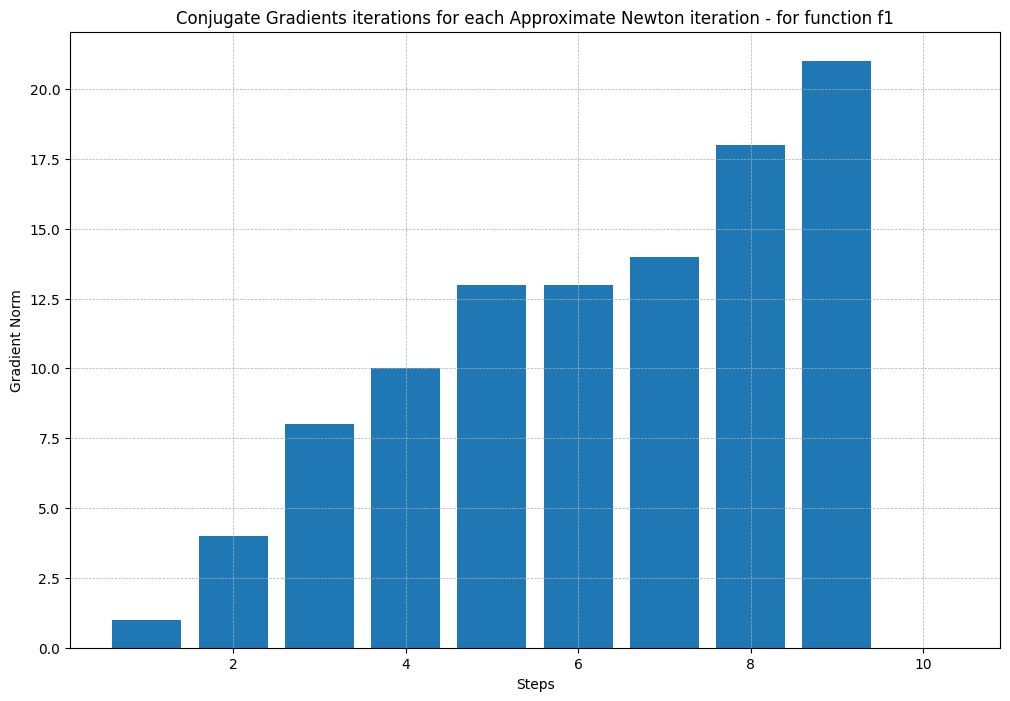

In [320]:
# print(df_results.iloc[0,8])
# print(df_results.iloc[1,8])
plt.figure(figsize=(12, 8))
plt.bar(range(1 ,df_results.iloc[0,2]+1), df_results.iloc[0,8])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title(f"Conjugate Gradients iterations for each Approximate Newton iteration - for function {df_results.iloc[0,0]}")
# plt.yscale("log")
# plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

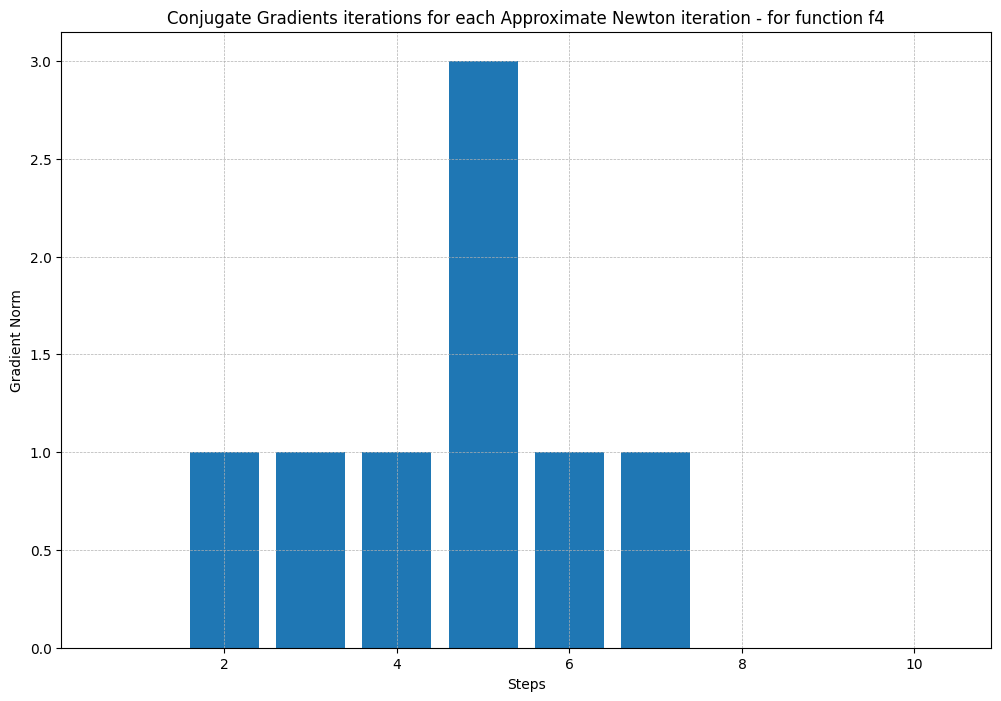

In [321]:
# print(df_results.iloc[0,8])
# print(df_results.iloc[1,8])
plt.figure(figsize=(12, 8))
plt.bar(range(1 ,df_results.iloc[1,2]+1), df_results.iloc[1,8])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title(f"Conjugate Gradients iterations for each Approximate Newton iteration - for function {df_results.iloc[1,0]}")
# plt.yscale("log")
# plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Approximate newton
Approximate newton


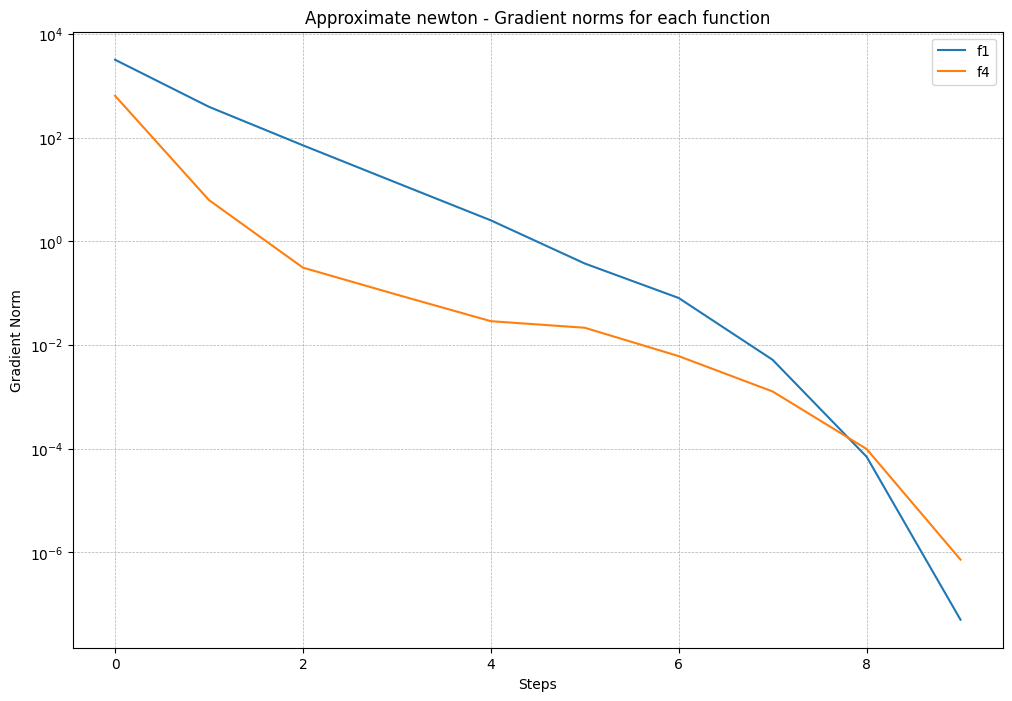

In [310]:
plt.figure(figsize=(12, 8))
for i in range(2):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
    print(df_results.iloc[i,1])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Approximate newton - Gradient norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Original newton
Original newton


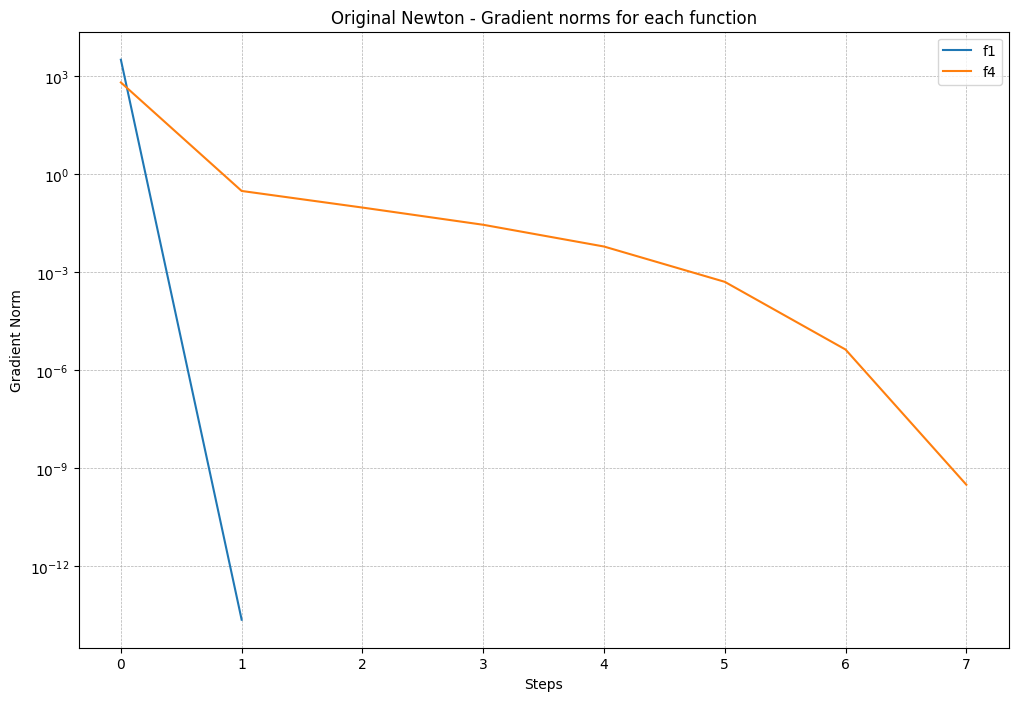

In [311]:
plt.figure(figsize=(12, 8))
for i in range(2,4):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
    print(df_results.iloc[i,1])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Original Newton - Gradient norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Steepest descent
Steepest descent


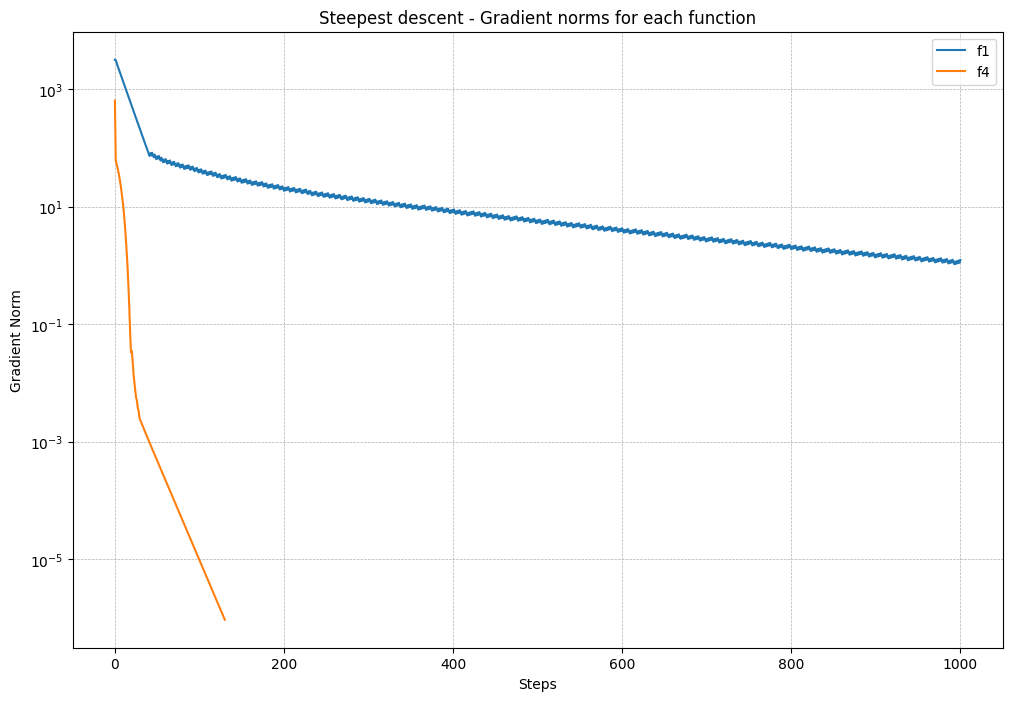

In [312]:
plt.figure(figsize=(12, 8))
for i in range(4,6):
    plt.plot(range(len(df_results.iloc[i,7])), df_results.iloc[i,7], label=f"{df_results.iloc[i,0]}")
    print(df_results.iloc[i,1])
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title("Steepest descent - Gradient norms for each function")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()